In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, InputLayer

In [3]:
prices = pd.read_csv('../Functions/csv_files/prices/train.csv')
technical_30 = pd.read_csv('../Functions/csv_files/technical_data/train_period_30.csv')

In [4]:
print(len(prices))
print(len(technical_30))

3054769
1202688


Here, we would like to implement a multivariate time series LSTM model that utilizes historical prices along with technical indicators to predict prices.

In [5]:
t = pd.merge(technical_30, prices, how='inner', on=['date', 'ticker'])
t['date'] = pd.to_datetime(t['date'], format='%Y-%m-%d')

<AxesSubplot: xlabel='date'>

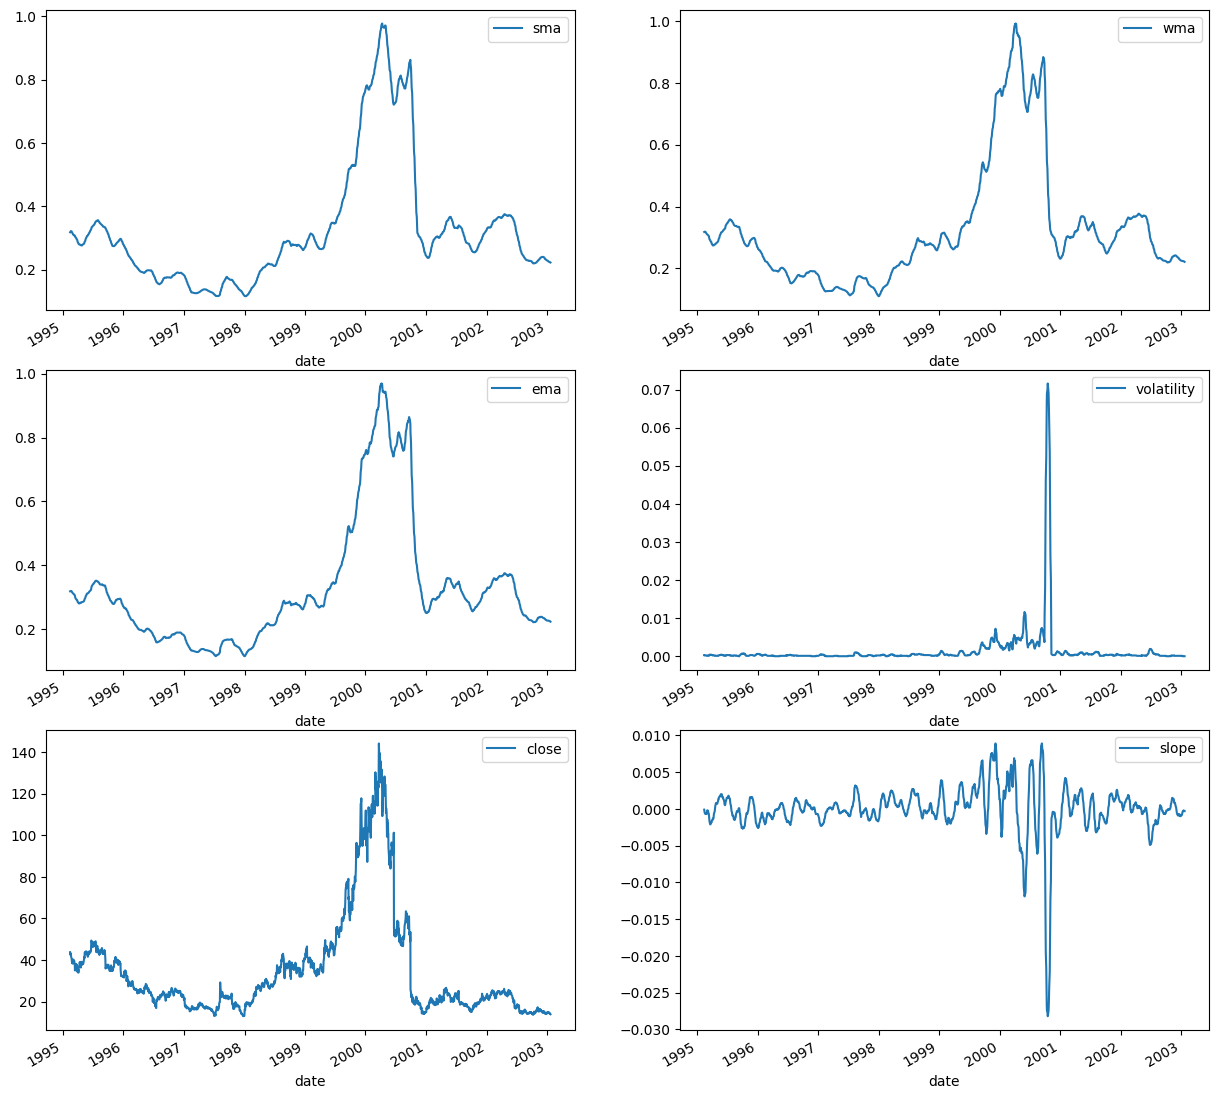

In [22]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

#add DataFrames to subplots
df1 = t.head(2000)[['date', 'sma']]
df2 = t.head(2000)[['date', 'wma']]
df3 = t.head(2000)[['date', 'ema']]
df4 = t.head(2000)[['date', 'volatility']]
df5 = t.head(2000)[['date', 'close']]
df6 = t.head(2000)[['date', 'slope']]


df1.plot(ax=axes[0, 0], x = 'date')
df2.plot(ax=axes[0, 1], x = 'date')
df3.plot(ax=axes[1, 0], x = 'date')
df4.plot(ax=axes[1, 1], x = 'date')
df5.plot(ax=axes[2, 0], x = 'date')
df6.plot(ax=axes[2, 1], x = 'date')

In [20]:
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1202688 entries, 0 to 1202687
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            1202688 non-null  datetime64[ns]
 1   sma             1202688 non-null  float64       
 2   ema             1202688 non-null  float64       
 3   wma             1202688 non-null  float64       
 4   volatility      1202688 non-null  float64       
 5   k_values        1202688 non-null  float64       
 6   d_values        1202688 non-null  float64       
 7   slope           1202688 non-null  float64       
 8   ticker          1202688 non-null  object        
 9   open            1202688 non-null  float64       
 10  high            1202688 non-null  float64       
 11  low             1202688 non-null  float64       
 12  close           1202688 non-null  float64       
 13  adjusted_close  1202688 non-null  float64       
 14  volume          12

In [7]:
"""
We need to reshape the data to create a windowed dataframe
"""
from sklearn import preprocessing

class Pipeline:
	def __init__(self, dataframe):
		self.dataframe = dataframe
		self.X = []
		self.Y = []
		self.n = 100

		if len(dataframe) <= self.n:
			raise Exception("Dataframe is too small for the given n!")
		else:
			self.transform()

	def get_x(self):
		return np.array(self.X)

	def get_y(self):
		return np.array(self.Y)

	def transform(self):
		for price in range(self.n + 1, len(self.dataframe)):
			self.split(self.dataframe.iloc[price - self.n - 1: price])

	def split(self, subset):
		# all items have to be the same ticker
		if len(subset['ticker'].unique().tolist()) > 1:
			return
		subset = subset.drop(columns=['ticker'])
		x = subset.head(self.n)
		y = subset.tail(1)['adjusted_close']
		x.index = x.date
		x = x.drop(columns=['date'])
		self.X.append(x.to_numpy())
		self.Y.append(y.values[0])

In [8]:
temp = Pipeline(t.iloc[10000:70000])

In [15]:
temp.get_x().size

76438700

In [17]:
model = Sequential()
model.add(InputLayer((100, 13)))
model.add(LSTM(512))
model.add(Dense(25, 'linear'))
model.add(Dense(64, 'linear'))
model.add(Dense(8, 'linear'))
model.add(Dense(1, 'linear'))
model.compile(optimizer='Adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 512)               1077248   
                                                                 
 dense_3 (Dense)             (None, 25)                12825     
                                                                 
 dense_4 (Dense)             (None, 64)                1664      
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,092,266
Trainable params: 1,092,266
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(temp.get_x(), temp.get_y(), epochs = 10)

Epoch 1/10
1838/1838 [==============================] - 1794s 974ms/step - loss: 4099.2261
Epoch 2/10
1838/1838 [==============================] - 6627s 4s/step - loss: 4072.9778
Epoch 3/10
1697/1838 [==========================>...] - ETA: 7:49 - loss: 4071.8594

KeyboardInterrupt: 